### Machine Learning Audio Classificaiton MFCC VGG
In this document we will read in our feature npy files, construct, train and evaluate a model for audio classification:

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import random
import math
#from netplot import ModelPlot
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# set the random seed
tf.random.set_seed(42)

# are we resuming training?
resume = False

2.7.0
Num GPUs Available:  1


2022-01-29 12:54:40.856132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 12:54:40.951981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 12:54:40.952273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Core VGG Structures
A VGG can be called an upgraded version of the VGG architecture, with the difference between them being the skip connections used in ResNets. In the figure below, we can see the architecture of the VGG as well as the 34 layer ResNet.



In [2]:
def vgg_style(x):
    """
    The original feature extraction structure from CRNN paper.
    Related paper: https://ieeexplore.ieee.org/abstract/document/7801919
    """
    x = tf.keras.layers.Conv2D(
        64, 3, padding='same', activation='relu', name='conv1')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, padding='same', name='pool1')(x)

    x = tf.keras.layers.Conv2D(
        128, 3, padding='same', activation='relu', name='conv2')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2, padding='same', name='pool2')(x)

    x = tf.keras.layers.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = tf.keras.layers.BatchNormalization(name='bn3')(x)
    x = tf.keras.layers.Activation('relu', name='relu3')(x)
    x = tf.keras.layers.Conv2D(
        256, 3, padding='same', activation='relu', name='conv4')(x)
    x = tf.keras.layers.MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool4')(x)

    x = tf.keras.layers.Conv2D(512, 3, padding='same', use_bias=False, name='conv5')(x)
    x = tf.keras.layers.BatchNormalization(name='bn5')(x)
    x = tf.keras.layers.Activation('relu', name='relu5')(x)
    x = tf.keras.layers.Conv2D(
        512, 3, padding='same', activation='relu', name='conv6')(x)
    x = tf.keras.layers.MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool6')(x)

    x = tf.keras.layers.Conv2D(512, 2, use_bias=False, name='conv7')(x)
    x = tf.keras.layers.BatchNormalization(name='bn7')(x)
    x = tf.keras.layers.Activation('relu', name='relu7')(x)

    x = tf.keras.layers.Reshape((-1, 512), name='reshape7')(x)
    return x

### MFCC FEATURE READ IN
In this section we will read in our kaggle 2018 dataset which have already been featured extracted and normalized

In [3]:
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')
data_npy_folder = os.path.join(dataset_root_dir, 'data')

# load the training data
dataset_train_folder = os.path.join(dataset_root_dir, 'train')
dataset_train_csv = os.path.join(dataset_train_folder, 'catalog.csv')

In [4]:
# os path to desktop
#desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')

# load in our data_frame
metadata = pd.read_csv(dataset_train_csv)

# Pre-processed MFCC coefficients
X = np.load( os.path.join(data_npy_folder, "X-mfcc.npy" ) )
y = np.load( os.path.join(data_npy_folder, "y-mfcc.npy" ) )


In [5]:
# create train and test sets
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))


Test split: 1894 		 Train split: 7579
X test shape: (1894, 40, 2584) 	 X train shape: (7579, 40, 2584)
y test shape: (1894,) 		 y train shape: (7579,)


### visualize the label count distribution for train and test data

#### train label count distribution

<BarContainer object of 41 artists>

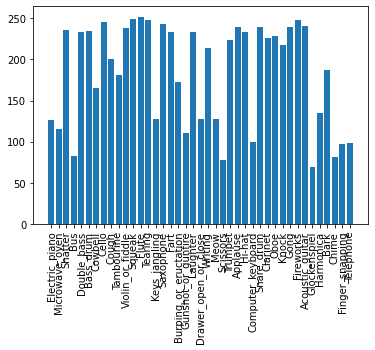

In [6]:
# visualize the label count distribution
labels = dict(zip(y_train,map(list(y_train).count, y_train)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

#### test label count distribution

<BarContainer object of 41 artists>

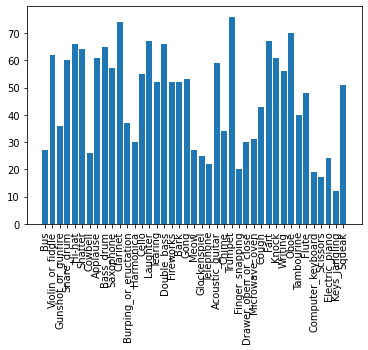

In [7]:
labels = dict(zip(y_test,map(list(y_test).count, y_test)))
plt.xticks(rotation='vertical')
plt.bar(labels.keys(), labels.values())

In [8]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))


In [9]:
y_test[2], y_test_encoded[2]

('Gunshot_or_gunfire',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [10]:
# How data should be structured
num_rows = 40
num_columns = 2584 
num_channels = 1

# Reshape to fit the network input (channel last)

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]
num_labels

41

In [11]:

input_shape = (num_rows, num_columns, num_channels)

if resume is False:
    model = tf.keras.applications.vgg16.VGG16(
        include_top=True, weights=None, input_tensor=None,
        input_shape=input_shape, pooling=None, classes=num_labels,
        classifier_activation='softmax'
    )#vgg_style() #ResNet34(input_shape, num_labels)

# # Regularizatio

2022-01-29 12:54:48.343097: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-29 12:54:48.345684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 12:54:48.346535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-29 12:54:48.347282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### compile and visualise the model
Yes, batch size affects Adam optimizer. Common batch sizes 16, 32, and 64 can be used. Results show that there is a sweet spot for batch size, where a model performs best. For example, on MNIST data, three different batch sizes gave different accuracy as shown in the table below:
```
|Batch Size | Test Accuracy        |
-----------------------------------|
|1024       |  96% with 30 epochs  |
|64         |  98% with 30 epochs  |
|2          |  99% with 30 epochs  |
|__________________________________|
```
https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer

In [12]:

# TODO: source of this model was made from https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/
# TODO: this may be useful charles for learning rates justification https://arxiv.org/pdf/1908.06477.pdf
# 2. compile the model
if resume is False:
    learing_rate = 0.000005#1e-4#0.01
    beta_1 = 0.99
    beta_2 = 0.999

    num_epochs = 10#250#500
    num_batch_size = 8#16#32#32#16 # NOTE: for resnets batch size seems to be the best hyper parameter that improves performance


# 0.0465 loss val
# learing_rate = 0.000005#1e-4#0.01
# beta_1 = 0.99
# beta_2 = 0.999

# num_epochs = 5#250#500
# num_batch_size = 16#16

    model.compile(
        loss = tf.keras.losses.mae, # mean absolute error predicted vs observed
        # previous failure training used 1e-4, beta_1=0.99, beta_2=0.999, only achieved a val_loss did not improve from 0.04701
        optimizer = tf.keras.optimizers.Adam(learning_rate=learing_rate, beta_1=beta_1, beta_2=beta_2), # stochastic gradient descent (lr=1e-3)
        metrics=['mae'] # mean absolute error
    )

### visualise the model

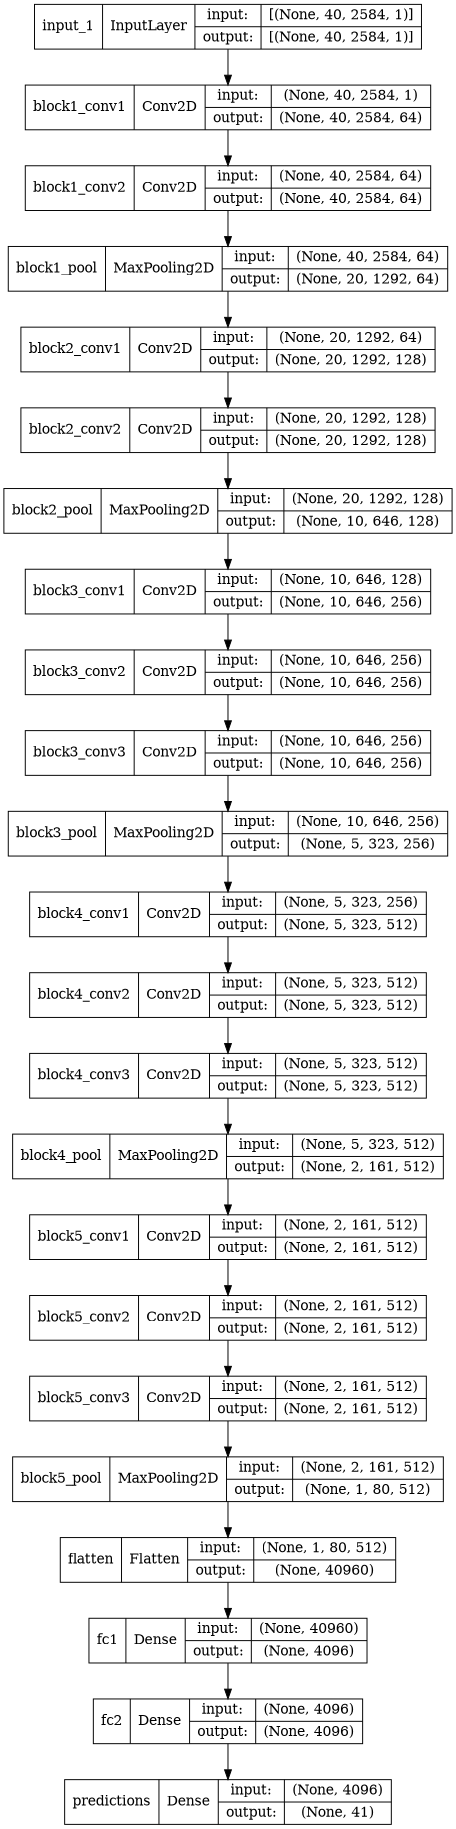

In [13]:
#if resume is False:
plot_model(model, show_shapes=True, expand_nested=True, dpi=70)

### train the model

In [14]:
# modelplot = ModelPlot(model=model, grid=True, connection=False, linewidth=0.1)
# modelplot.show()
model_dir = os.path.join( dataset_root_dir, 'models')
# get the directory of the model output
if resume is False:
    model_path = os.path.join(model_dir, f'K2018_MFCC_VGG16_lr-{learing_rate}_b1-{beta_1}_b2-{beta_2}_EPOCH-{num_epochs}_BATCH-{num_batch_size}.h5')
else:
    num_epochs = 250
    num_batch_size = 32 # recommend keeping same as saved model
    print("Resuming training...")
    model_path = os.path.join(model_dir, 'K2018_MFCC_VGG16_lr-5e-06_b1-0.99_b2-0.999_EPOCH-10_BATCH-32.h5')
    # Load best saved model
    print("Loading best saved model...")
    model = load_model(model_path)

model_path

'/home/charlesedwards/Documents/kaggle_2018_dataset/models/K2018_MFCC_VGG16_lr-5e-06_b1-0.99_b2-0.999_EPOCH-10_BATCH-8.h5'

In [15]:

# Save checkpoints
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path, 
    verbose=1, 
    save_best_only=True
)

# # early stopping callback
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='mae',
#     patience=3
# )

from datetime import datetime
start = datetime.now()

# 3. train the model

history = model.fit(
    X_train, 
    y_train_encoded, 
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    validation_split=1/12.,
    callbacks=[checkpointer], 
    verbose=1
)

# history = model.fit(
#     X_train,
#     y_train_encoded,
#     epochs=250,
#     verbose=1,
#     callbacks=[early_stopping_callback, checkpointer],
#     validation_data=(X_test, y_test_encoded)
# )

end = datetime.now() - start
print("Training time: {}".format(end))

2022-01-29 12:54:49.389898: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2872167680 exceeds 10% of free system memory.
2022-01-29 12:54:50.920015: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2872167680 exceeds 10% of free system memory.


Epoch 1/10


2022-01-29 12:54:53.508097: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302
2022-01-29 12:54:54.026577: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-29 12:54:54.059811: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-29 12:54:54.517575: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

  1/869 [..............................] - ETA: 52:23 - loss: 0.0476 - mae: 0.0476

2022-01-29 12:54:55.459507: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-29 12:54:55.546551: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 925.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


868/869 [============================>.] - ETA: 0s - loss: 0.0476 - mae: 0.0476

2022-01-29 12:58:41.272795: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


869/869 [==============================] - ETA: 0s - loss: 0.0476 - mae: 0.0476
Epoch 00001: val_loss improved from inf to 0.04759, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/K2018_MFCC_VGG16_lr-5e-06_b1-0.99_b2-0.999_EPOCH-10_BATCH-8.h5


2022-01-29 12:58:47.921223: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 671088640 exceeds 10% of free system memory.
2022-01-29 12:58:49.013131: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 671088640 exceeds 10% of free system memory.
2022-01-29 12:58:49.934858: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 671088640 exceeds 10% of free system memory.


869/869 [==============================] - 242s 274ms/step - loss: 0.0476 - mae: 0.0476 - val_loss: 0.0476 - val_mae: 0.0476
Epoch 2/10
869/869 [==============================] - ETA: 0s - loss: 0.0476 - mae: 0.0476
Epoch 00002: val_loss improved from 0.04759 to 0.04716, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/K2018_MFCC_VGG16_lr-5e-06_b1-0.99_b2-0.999_EPOCH-10_BATCH-8.h5
869/869 [==============================] - 240s 276ms/step - loss: 0.0476 - mae: 0.0476 - val_loss: 0.0472 - val_mae: 0.0472
Epoch 3/10
869/869 [==============================] - ETA: 0s - loss: 0.0470 - mae: 0.0470
Epoch 00003: val_loss improved from 0.04716 to 0.04674, saving model to /home/charlesedwards/Documents/kaggle_2018_dataset/models/K2018_MFCC_VGG16_lr-5e-06_b1-0.99_b2-0.999_EPOCH-10_BATCH-8.h5
869/869 [==============================] - 238s 274ms/step - loss: 0.0470 - mae: 0.0470 - val_loss: 0.0467 - val_mae: 0.0467
Epoch 4/10
869/869 [==============================] - ETA

Text(0.5, 0, 'epochs')

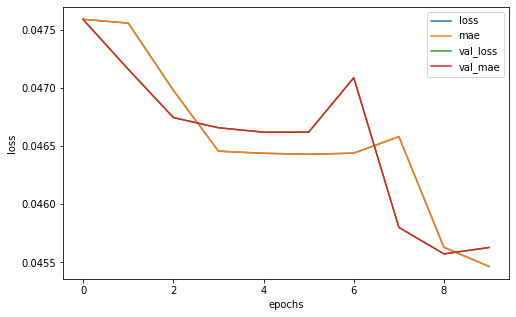

In [16]:
# plot history also known as loss curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.ylabel("loss")
plt.xlabel("epochs")

In [18]:
#model_path = os.path.join(model_dir, 'K2018_MFCC_RESNET32_lr-5e-06_b1-0.99_b2-0.999_EPOCH-10_BATCH-32.h5')

# Load best saved model
model = load_model(model_path)

# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# test_score = model.evaluate(X_test, y_test, verbose=0)
# test_score
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     #train_score = model.evaluate(X_train, y_train, verbose=0)
#     test_score = model.evaluate(X_test, y_test, verbose=0)
#     return test_score#train_score, test_score


# def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
#     dash = '-' * 38

#     # Compute scores
#     train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)

#     # Pint Train vs Test report
#     print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
#     print(dash)
#     print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
#     print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))


#     # Calculate and report normalized error difference?
#     if (calc_normal):
#         max_err = max(train_score[0], test_score[0])
#         error_diff = max_err - min(train_score[0], test_score[0])
#         normal_diff = error_diff * 100 / max_err
#         print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

#length = len(a_list)

#model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)


2022-01-29 13:43:40.485609: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 746.78MiB (rounded to 783055360)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-01-29 13:43:40.485676: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-01-29 13:43:40.485702: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 74, Chunks in use: 74. 18.5KiB allocated for chunks. 18.5KiB in use in bin. 4.7KiB client-requested in use in bin.
2022-01-29 13:43:40.485720: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 14, Chunks in use: 14. 7.2KiB allocated for chunks. 7.2KiB in use in bin. 7.0KiB client-requested in use in bin.
2022-01-29 13:43:40.485738: 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

ze: 64.00MiB | Requested Size: 64.00MiB | in_use: 1 | bin_num: -1, next:   Size: 640.00MiB | Requested Size: 640.00MiB | in_use: 1 | bin_num: -1
2022-01-29 13:43:40.486069: I tensorflow/core/common_runtime/bfc_allocator.cc:1039]   Size: 640.00MiB | Requested Size: 640.00MiB | in_use: 0 | bin_num: 20, prev:   Size: 640.00MiB | Requested Size: 640.00MiB | in_use: 1 | bin_num: -1, next:   Size: 640.00MiB | Requested Size: 640.00MiB | in_use: 1 | bin_num: -1
2022-01-29 13:43:40.486077: I tensorflow/core/common_runtime/bfc_allocator.cc:1046] Next region of size 7384662016
2022-01-29 13:43:40.486086: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f1da2000000 of size 1280 next 1
2022-01-29 13:43:40.486094: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f1da2000500 of size 256 next 2
2022-01-29 13:43:40.486101: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f1da2000600 of size 256 next 3
2022-01-29 13:43:40.486108: I tensorflow/core/comm

In [ ]:

model.metrics_names

['loss', 'mae']

ValueError: The number of FixedLocator locations (41), usually from a call to set_ticks, does not match the number of ticklabels (1894).

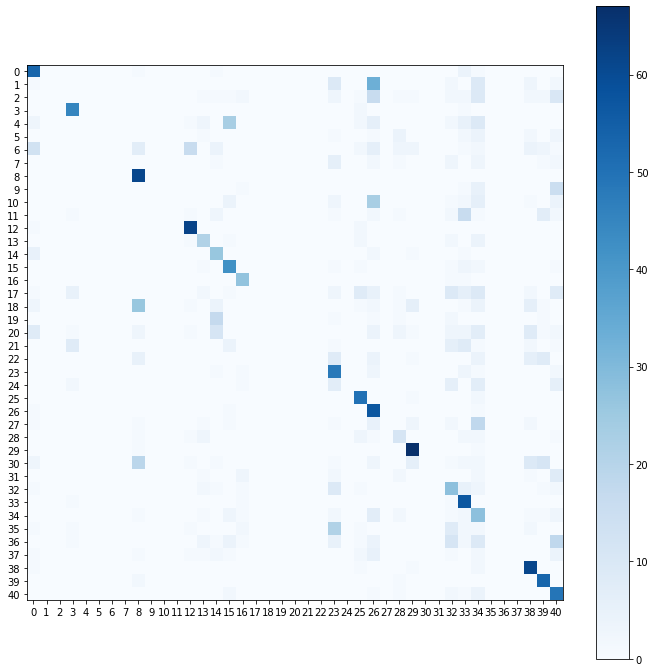

In [ ]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

# Plots a confussion matrix
def plot_confusion_matrix(cm,
                          classes, 
                          normalized=False, 
                          title=None, 
                          cmap=plt.cm.Blues,
                          size=(10,10)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalized else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

plot_confusion_matrix(
    cm,
    y_test, 
    normalized=False, 
    title="Model Performance", 
    cmap=plt.cm.Blues,
    size=(12,12))

### Resume Training